In [12]:
# the imports
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import plotly.express as px
import plotly.graph_objects as go

#file path and cloumns
CSV_PATH = "sunrise_humidity.csv"   
TEMP_COLS = ["temperature", "temp", "Temperature", "Temp_C", "TempF"]
HUM_COLS  = ["humidity", "Humidity", "RH", "rh_pct"]                   

# Reads the CSV without headers
df = pd.read_csv(CSV_PATH, header=None)

# Renames columns to timestamp, temperature, humidity
df = df.rename(columns={0: "timestamp", 1: "temperature", 2: "humidity"})

# Drop rows with missing values
df = df.dropna(subset=["temperature", "humidity"])

# Convert to numeric if values are string
df["temperature"] = pd.to_numeric(df["temperature"], errors="coerce")
df["humidity"]    = pd.to_numeric(df["humidity"], errors="coerce")

df.head()

timestamp  temperature  humidity
0  20250801014447         19.1      48.8
1  20250801014517         19.1      49.0
2  20250801014547         19.0      49.2
3  20250801014617         18.9      49.4
4  20250801014647         18.9      49.4

In [19]:

# trains the LR model where hum predicts temp and makes a grid of 100 temp values for predictions
def fit_predict(df_in):
    X = df_in[["temperature"]].values  # (n,1)
    y = df_in["humidity"].values

    model = LinearRegression()
    model.fit(X, y)
# finds max and min temps of the data set, it can be used to predict 
    t_min, t_max = float(df_in["temperature"].min()), float(df_in["temperature"].max())
    t_grid = np.linspace(t_min, t_max, 100).reshape(-1, 1)
    y_pred_grid = model.predict(t_grid)

    # stores the model satistics 
    y_pred_train = model.predict(X)
    metrics = {
        "slope": float(model.coef_[0]),
        "intercept": float(model.intercept_),
        "r2_train": float(r2_score(y, y_pred_train)),
        "t_min": t_min, "t_max": t_max
    }
    return model, t_grid.flatten(), y_pred_grid, metrics

model0, t_grid0, y_grid0, m0 = fit_predict(df)
m0

{'slope': -1.6653067334760228,
 'intercept': 81.79514381680626,
 'r2_train': 0.2065943697906244,
 't_min': 15.6,
 't_max': 19.1}

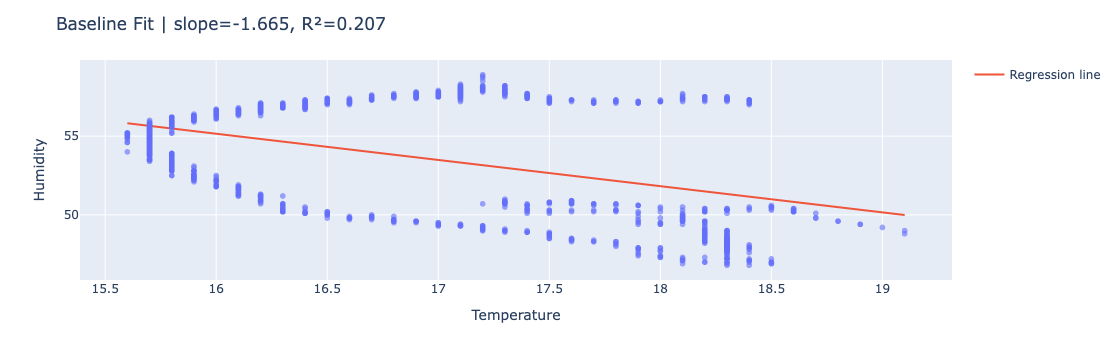

In [20]:
# defines function and the paramaters hum and temp, temp values from grid and predicted hum values in response to grid
def plot_fit(df_in, t_grid, y_grid, title="Temperature vs Humidity (LR)"):
    fig = px.scatter(df_in, x="temperature", y="humidity", opacity=0.6,
                     labels={"temperature": "Temperature", "humidity": "Humidity"})
    #creating the scatterplot
    fig.add_traces(go.Scatter(x=t_grid, y=y_grid, mode="lines", name="Regression line"))
    fig.update_layout(title=title)
    fig.show()

plot_fit(df, t_grid0, y_grid0, title=f"Baseline Fit | slope={m0['slope']:.3f}, R²={m0['r2_train']:.3f}")

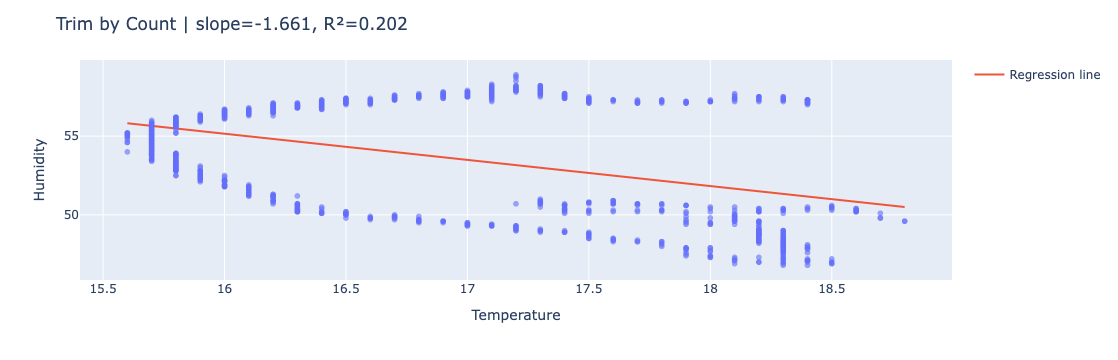

In [21]:
def trim_by_count(df_in, low_drop=5, high_drop=5):
    d = df_in.sort_values("temperature").copy()
    if low_drop + high_drop >= len(d):
        raise ValueError("Trim too aggressive for dataset size.")
    return d.iloc[low_drop: len(d)-high_drop]

df_trimA = trim_by_count(df, low_drop=5, high_drop=5)
modelA, t_gridA, y_gridA, mA = fit_predict(df_trimA)
plot_fit(df_trimA, t_gridA, y_gridA, title=f"Trim by Count | slope={mA['slope']:.3f}, R²={mA['r2_train']:.3f}")

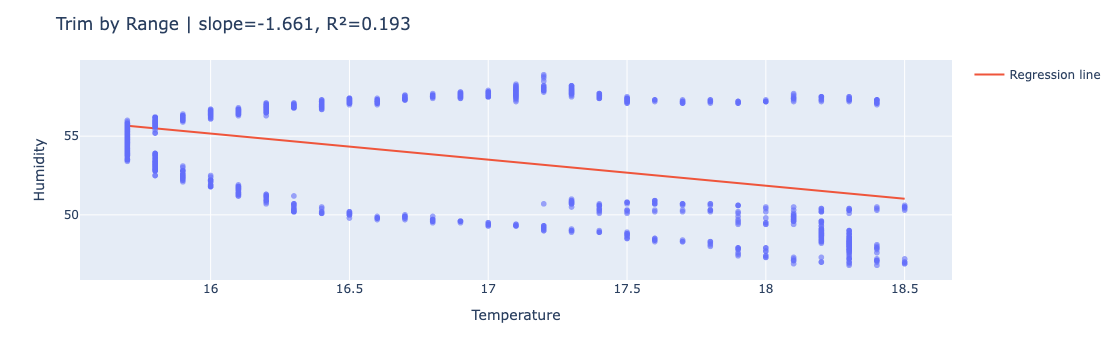

In [22]:
TEMP_MIN, TEMP_MAX = df["temperature"].quantile(0.02), df["temperature"].quantile(0.98)
df_trimB = df[(df["temperature"] >= TEMP_MIN) & (df["temperature"] <= TEMP_MAX)].copy()

modelB, t_gridB, y_gridB, mB = fit_predict(df_trimB)
plot_fit(df_trimB, t_gridB, y_gridB, title=f"Trim by Range | slope={mB['slope']:.3f}, R²={mB['r2_train']:.3f}")

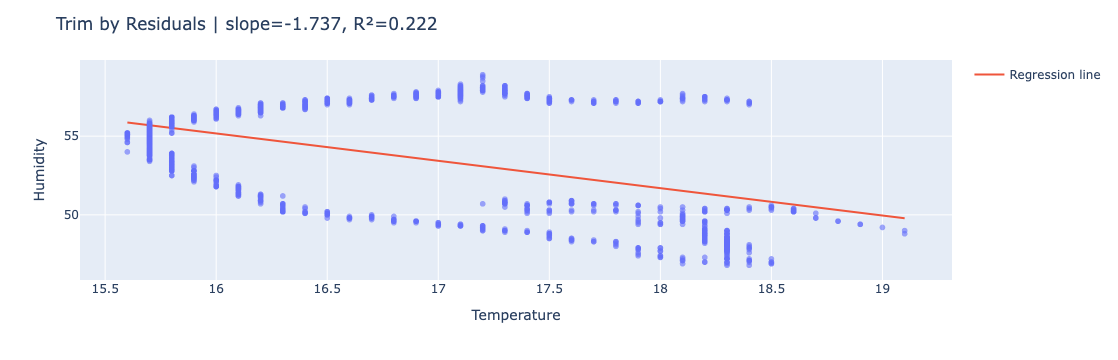

In [24]:
#residuals versus baseline model
X_all = df[["temperature"]].values
y_all = df["humidity"].values
y_hat_all = model0.predict(X_all)
resid = y_all - y_hat_all
df_resid = df.assign(residual=resid, abs_resid=np.abs(resid))

K = 10 
df_trimC = df_resid.sort_values("abs_resid").iloc[:-K].drop(columns=["residual", "abs_resid"])

modelC, t_gridC, y_gridC, mC = fit_predict(df_trimC)
plot_fit(df_trimC, t_gridC, y_gridC, title=f"Trim by Residuals | slope={mC['slope']:.3f}, R²={mC['r2_train']:.3f}")